### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory created!
Directory created!


In [4]:
for i in ['RandomForest_full_set', 'SVM_poly', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory created!
Directory created!
Directory created!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [12]:
train=train[['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score','mini_sea_total', 'npi_total', 
       'mmse_vs','moca_vs', 'ace_vs' ]].dropna()

In [13]:
test=test[['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score','mini_sea_total', 'npi_total',
       'mmse_vs','moca_vs', 'ace_vs' ]].dropna()

In [119]:
# def impute_mean(group):
#     return group.fillna(group.mean())

# nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

# for i in nan_cols:
#     train[i] = train[i].transform(impute_mean)
    
# nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

# for i in nan_cols:
#     test[i] = test[i].transform(impute_mean)

In [14]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
#               'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
#               'pfeffer_total','cognition', 'functionality', 'marital_status', 'n_children',
#               'household_members', 'household_income', 'Job_status', 'strata']

# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs',
#               'functionality', 'marital_status', 'n_children', 'household_members', 'household_income',
#               'Job_status', 'strata']


# train = train[final_cols]
# test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [15]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'npi_total', 'mmse_vs', 'moca_vs',
       'ace_vs'],
      dtype='object')

In [16]:
train = train.drop(['site','id'], axis=1)
test = test.drop(['site','id'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((244, 10), (29, 10))

In [17]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [50]:
## Random Forest Hparams

rf_grid= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}

best, raw = bhs.hparams_search(data, 'diagnosis', RandomForestClassifier(), rf_grid, rf_param,
                               scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)

Best score: 0.868348717948718
	
Test score: 0.8794642857142858
	
Execution time: 3.2275855938593545 minutes


In [51]:
print(best)

{'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.14232599592847806, 'n_estimators': 25}


In [53]:
## Models Hparams
# RF
rf_params= {"n_estimators": 25,
    "criterion": 'gini',
    "max_depth": 6,
    "min_samples_split": 0.142325,
    "min_samples_leaf": 0.01,
    "max_features":1,
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

# #Poly
# poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
#               'gamma': poly_hp.loc[poly_row, "param_gamma"],
#                'coef0': poly_hp.loc[poly_row, "param_coef0"],
#                'degree': poly_hp.loc[poly_row, 'param_degree'],
#               "kernel":"poly","class_weight":"balanced", "verbose":0, 'max_iter':10**6}

# #XGBOOST
# xgb_params = {
#     'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
#     'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
#     'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
#     'colsample_bytree': xgb_hp.loc[xgb_row, 'param_colsample_bytree'],
#     'min_child_weight': xgb_hp.loc[xgb_row, 'param_min_child_weight'],
#     'gamma': 1,
#     'subsample':1.0,
# #     'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
#     'n_jobs': -1,
#     'verbosity':0,
#     'eval_metric':'auc',
#     'objective':'binary:logistic',
#     'use_label_encoder':None}

# # xgb_params ={'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 0.8045117829208245,
# #              'learning_rate': 0.06547359028644324, 'max_depth': 4, 'n_estimators': 100,
# #              'objective': 'binary:logistic', 'reg_alpha': 0.0, 'reg_lambda': 0.9798465147079346,
# #              'subsample': 0.8,'n_jobs': -1,'verbosity':0}

In [54]:
n_iter = 5000

### RF Model

##### Bootstrap

In [55]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=1,
                       min_samples_leaf=0.01, min_samples_split=0.142325,
                       n_estimators=25, n_jobs=-1)


Iterating: 100%|██████████████████| 5000/5000 [05:41<00:00, 14.62it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:5.699262074629465 minutes
empirical p-value: 0.0066


In [56]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-27/mean_res'

In [57]:
Model_res.to_csv(path_res+ "/RandomForest_full_set/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.832954
ROC_AUC        0.843655
Precision      0.552587
Recall         0.570029
Sensitivity    0.570029
Specificity    0.890469
F1             0.545322
Efron_pR2      0.066372
dtype: float64

In [58]:
print("%.4f" % Model_res['ROC_AUC'].mean())

0.8437


In [59]:
CI_df.to_csv(path_res+ "/RandomForest_full_set/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.01034,0.010067,0.013782,0.013723,0.013723,0.008657,0.013802,0.0069


In [60]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest_full_set/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
2,mini_sea_total,0.174657,0.045114
1,ifs_total_score,0.141559,0.038233
7,year_birth,0.120993,0.034029
0,ace_vs,0.117417,0.031468
3,mmse_vs,0.109399,0.031253
4,moca_vs,0.104191,0.029513
5,npi_total,0.098672,0.027624
8,years_education,0.087049,0.024811
6,sex,0.046063,0.019583


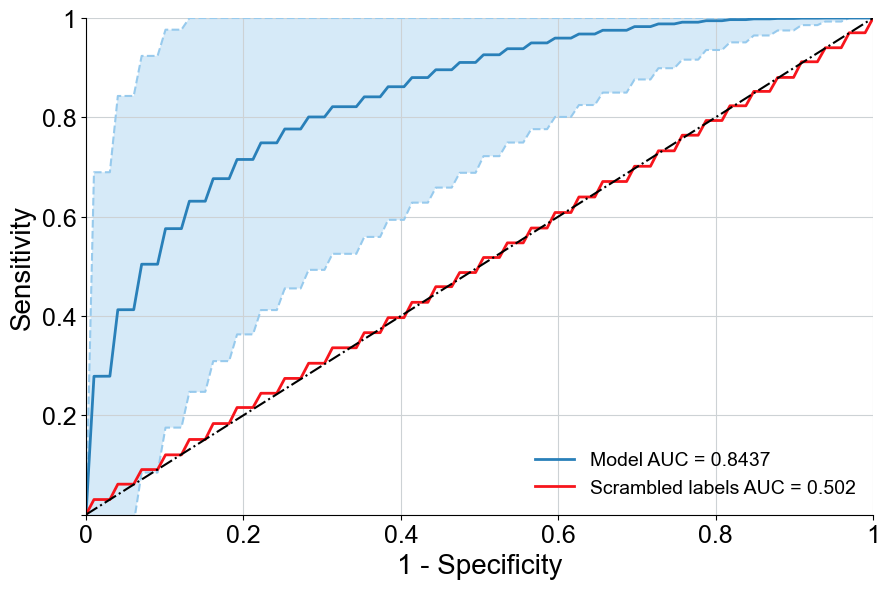

In [61]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest_full_set/ROC_AUC_curve.png")

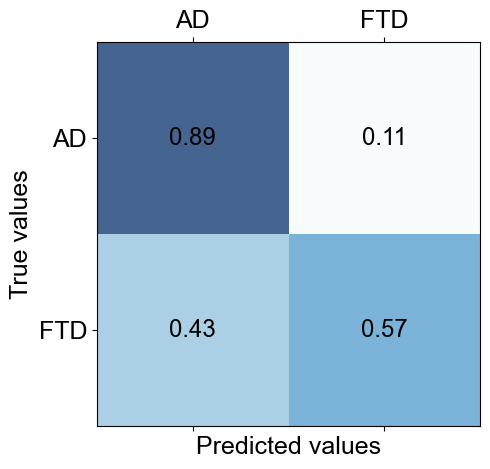

In [62]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_full_set/CM.png")

##### Permutation Feature importance

In [63]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [64]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest_full_set/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [65]:
top_10p.head()

,predictor,mean,std
4,mini_sea_total,0.073512,0.038103
6,mmse_vs,0.051932,0.028041
5,npi_total,0.042132,0.032438
1,sex,0.040834,0.042367
3,ifs_total_score,0.040790,0.054060


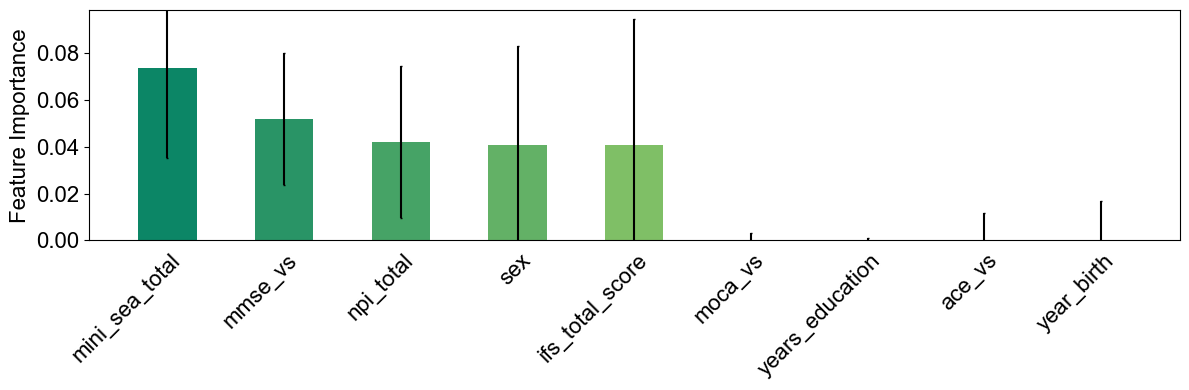

In [66]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [67]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
2,mini_sea_total,0.174657,0.045114
1,ifs_total_score,0.141559,0.038233
7,year_birth,0.120993,0.034029
0,ace_vs,0.117417,0.031468
3,mmse_vs,0.109399,0.031253


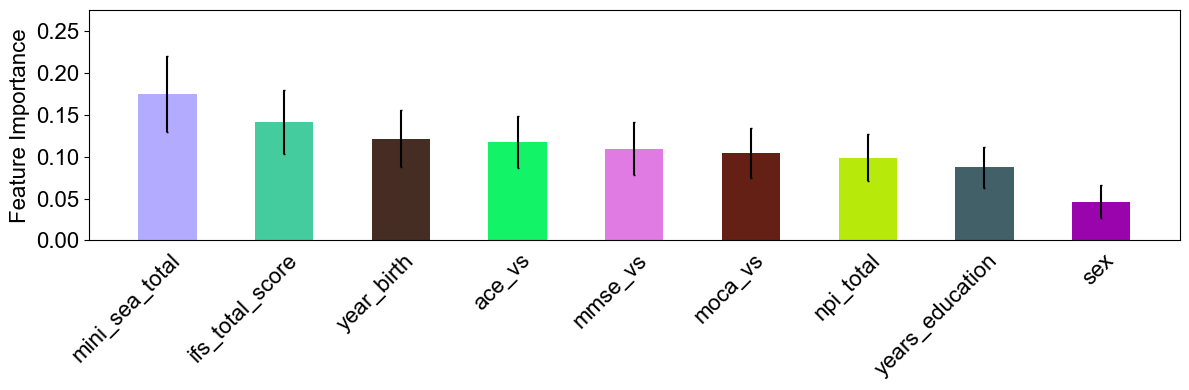

In [68]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [69]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [70]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [71]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [72]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest_full_set/unseen.csv")

In [73]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.75
Accuracy: 0.88
Recall: 0.5
F1: 0.6667
Precision:1.0


In [74]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.75
Bootstrping test ROC score: 	0.8437


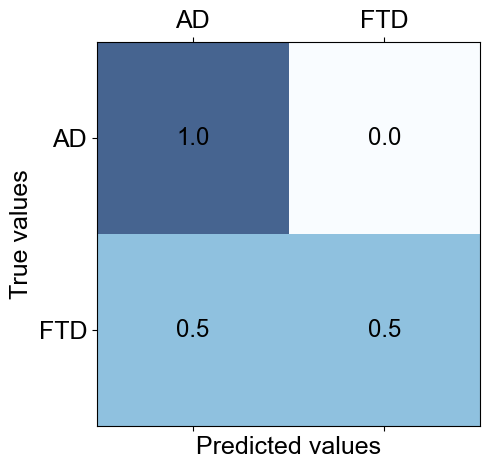

In [75]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest_full_set/CM_unseen.png")

#### Shapley

In [76]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


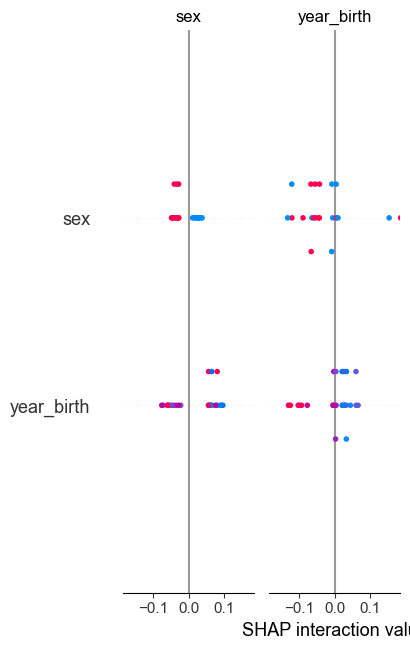

In [77]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

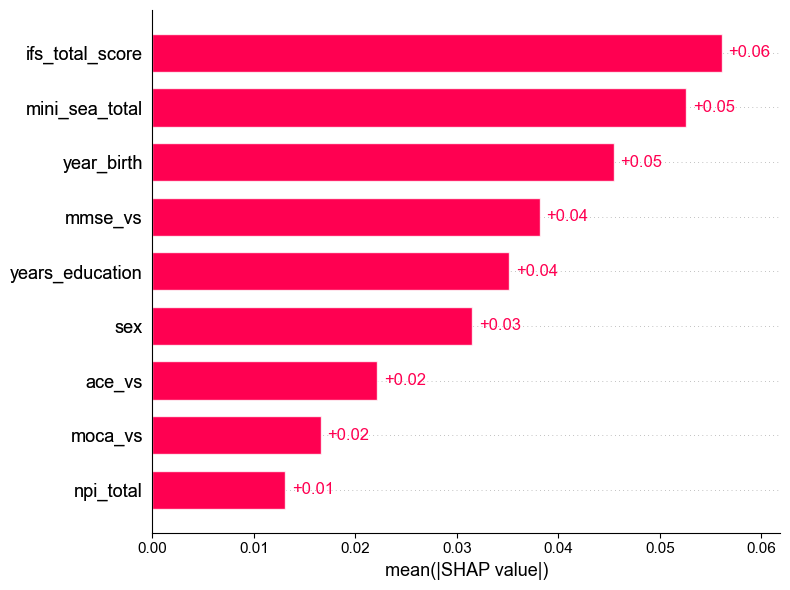

In [78]:
shap.plots.bar(shap_values[:,:,1])

### Sequential feature selector

#### RF

In [79]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [111]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)

In [112]:
# rf_params['max_features'] =1
X_train.shape

(193, 9)

In [120]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params), 
           k_features='best', 
           forward=True, 
           floating=False, 
            scoring='roc_auc',
           verbose=1,
           cv=cv, n_jobs =-1)

In [121]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.2s finished
Features: 1/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.2s finished
Features: 2/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 3/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
Features: 4/9[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
Features: 5/9[Parallel(n_jobs=-1)]: Using back

In [122]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [123]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.8258928571428571, 0.84375, 0.66071428571428...",0.772984,"(mini_sea_total,)",0.082593,0.06426,0.03213
2,"(4, 5)","[0.9196428571428572, 0.9084821428571428, 0.709...",0.815423,"(mini_sea_total, npi_total)",0.107605,0.08372,0.04186
3,"(4, 5, 6)","[0.9107142857142857, 0.9508928571428572, 0.727...",0.848272,"(mini_sea_total, npi_total, mmse_vs)",0.108796,0.084647,0.042323
4,"(4, 5, 6, 8)","[0.9017857142857143, 0.8772321428571428, 0.705...",0.856322,"(mini_sea_total, npi_total, mmse_vs, ace_vs)",0.098314,0.076491,0.038246
5,"(3, 4, 5, 6, 8)","[0.9107142857142857, 0.8705357142857143, 0.781...",0.870104,"(ifs_total_score, mini_sea_total, npi_total, m...",0.059893,0.046599,0.023299
6,"(0, 3, 4, 5, 6, 8)","[0.8928571428571428, 0.8660714285714286, 0.772...",0.865697,"(year_birth, ifs_total_score, mini_sea_total, ...",0.062086,0.048305,0.024152
7,"(0, 1, 3, 4, 5, 6, 8)","[0.8839285714285714, 0.8258928571428572, 0.794...",0.855732,"(year_birth, sex, ifs_total_score, mini_sea_to...",0.06088,0.047367,0.023683
8,"(0, 1, 2, 3, 4, 5, 6, 8)","[0.9285714285714286, 0.8973214285714286, 0.741...",0.852563,"(year_birth, sex, years_education, ifs_total_s...",0.084835,0.066005,0.033002
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)","[0.8883928571428572, 0.8571428571428572, 0.683...",0.830415,"(year_birth, sex, years_education, ifs_total_s...",0.096427,0.075024,0.037512


In [124]:
sfs_rf.to_csv("/home/marcelo/GitRepos/Tesis/pred_results/2023-11-27/mean_res/RandomForest_full_set/sfs_df.csv")

In [125]:
sfs_rf.loc[[7],:]

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
7,"(0, 1, 3, 4, 5, 6, 8)","[0.8839285714285714, 0.8258928571428572, 0.794...",0.855732,"(year_birth, sex, ifs_total_score, mini_sea_to...",0.06088,0.047367,0.023683


In [105]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[7, 'feature_names'])

In [106]:
sfs_rf_features

['year_birth',
 'sex',
 'years_education',
 'ifs_total_score',
 'mini_sea_total',
 'npi_total',
 'mmse_vs']

In [89]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

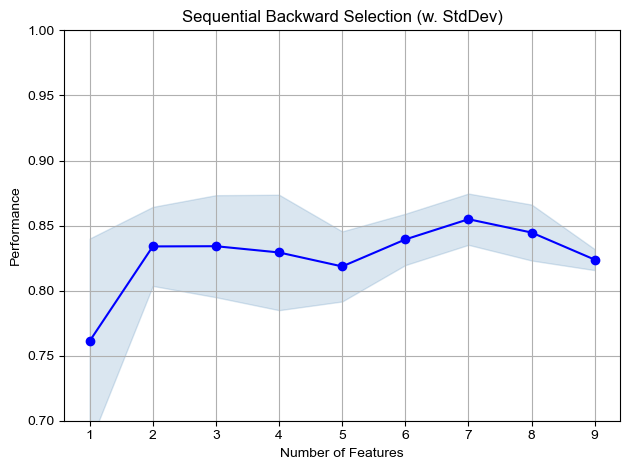

In [90]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [91]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

In [146]:
# shap.plots.force(shap_values[:,:,1])


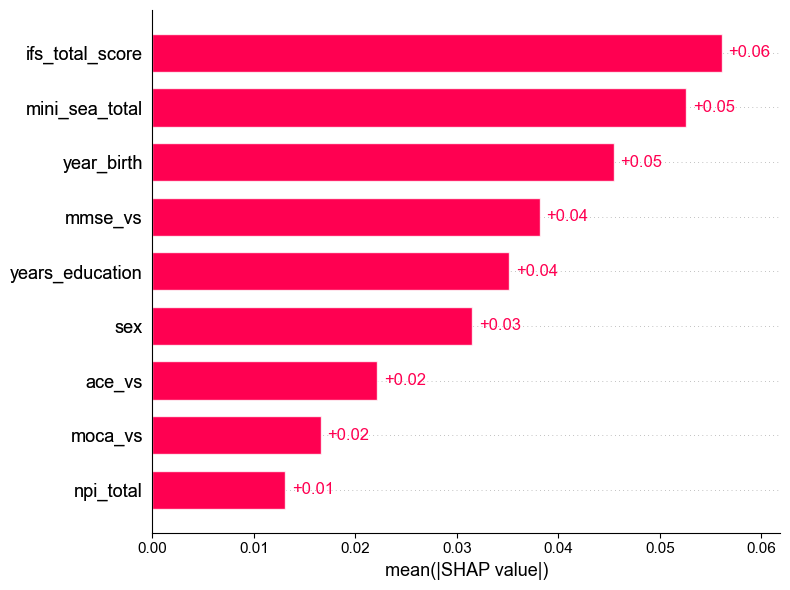

In [93]:
shap.plots.bar(shap_values[:,:,1])

#### RF with SFS

In [94]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data[sfs_rf_features + ['diagnosis']], 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=1,
                       min_samples_leaf=0.01, min_samples_split=0.142325,
                       n_estimators=25, n_jobs=-1)


Iterating: 100%|██████████████████| 5000/5000 [05:38<00:00, 14.76it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:5.646526233355204 minutes
empirical p-value: 0.0096


In [95]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-27/mean_res'

In [96]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res_sfs.csv", index=False)
Model_res.mean()

Accuracy       0.818759
ROC_AUC        0.836451
Precision      0.514812
Recall         0.570514
Sensitivity    0.570514
Specificity    0.873062
F1             0.526139
Efron_pR2      0.051623
dtype: float64

In [97]:
print("%.4f" % Model_res['ROC_AUC'].mean())

0.8365


In [98]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df_sfs.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010678,0.010252,0.013853,0.013721,0.013721,0.009228,0.01384,0.006133


In [99]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r_sfs.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)


,variables,Importance_mean,Importance_std
1,mini_sea_total,0.303434,0.053345
0,ifs_total_score,0.244688,0.048073
2,mmse_vs,0.205361,0.043216
3,npi_total,0.176154,0.035115
4,sex,0.070364,0.025620


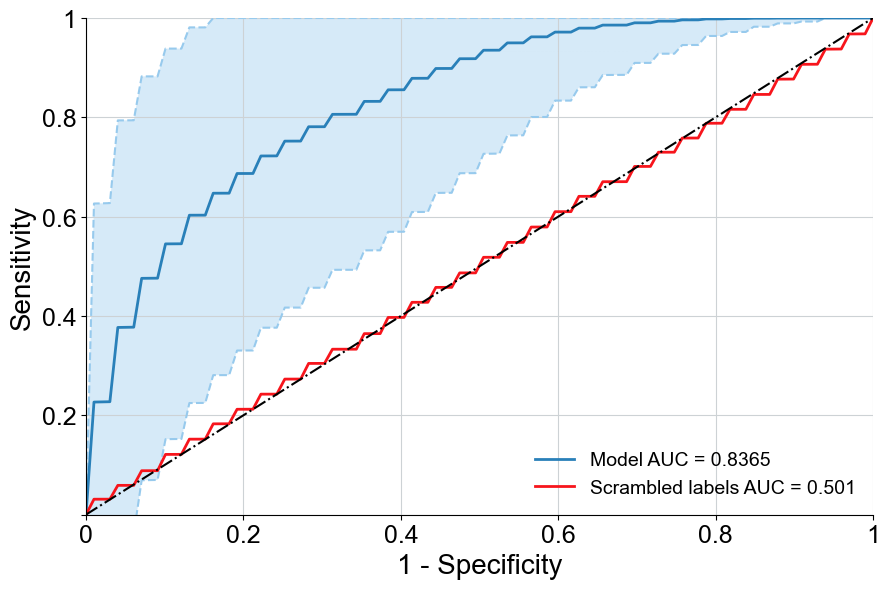

In [100]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve_sfs.png")
# Fig save?

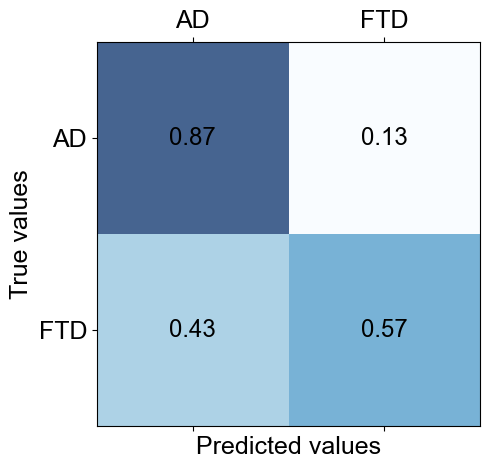

In [101]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM_sfs.png")

##### Permutation Feature importance

In [102]:
rf_fimp = bc.permutation_FIMP(data[sfs_rf_features + ['diagnosis']], 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [103]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI_sfs.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [266]:
top_10p.head()

,predictor,mean,std
0,ifs_total_score,0.218205,0.035729
3,ace_vs,0.080882,0.017689
2,npi_total_caregiver,0.025057,0.009759
1,mini_sea_total,0.006346,0.009283
4,household_members,0.004705,0.012139


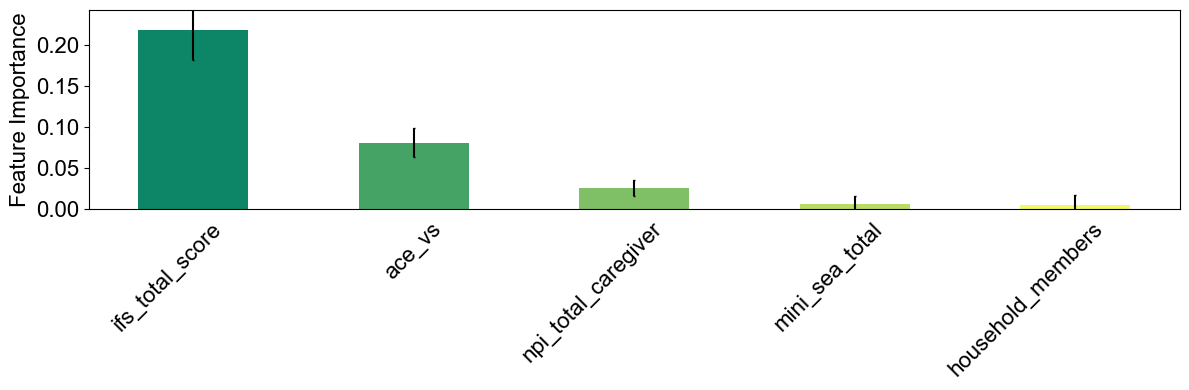

In [267]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [268]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
2,ifs_total_score,0.407794,0.021186
0,ace_vs,0.275697,0.020651
3,mini_sea_total,0.120814,0.011493
1,household_members,0.103454,0.012349
4,npi_total_caregiver,0.092241,0.010142


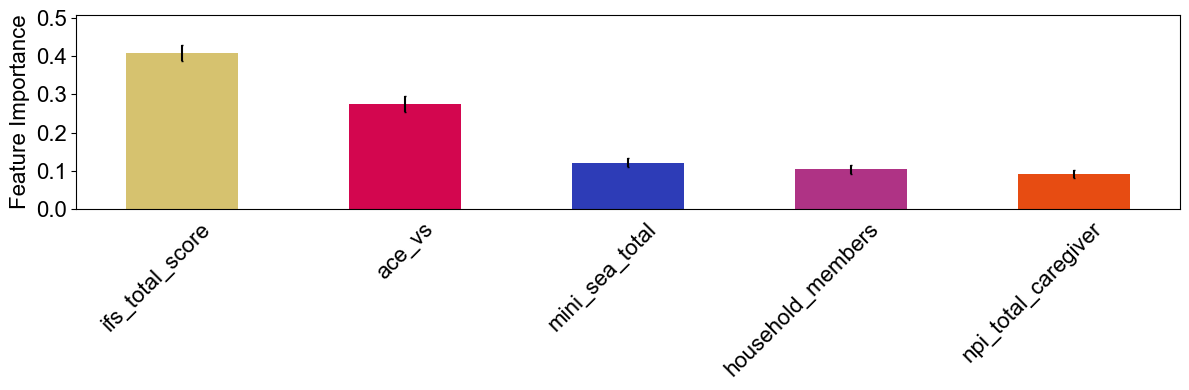

In [269]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

In [270]:
X_train = X_train[sfs_rf_features]
X_unseen = X_unseen[sfs_rf_features]

In [271]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [272]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen_sfs.csv")

In [273]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6607
Accuracy: 0.757
Recall: 0.48
F1: 0.48
Precision:0.48
Unseen Data ROC score: 		0.6607
Bootstrping test ROC score: 	0.8070


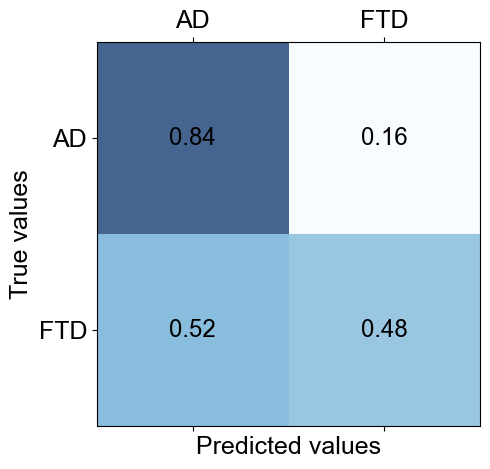

In [274]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM_unseen_sfs.png")

##### Shapley

In [275]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


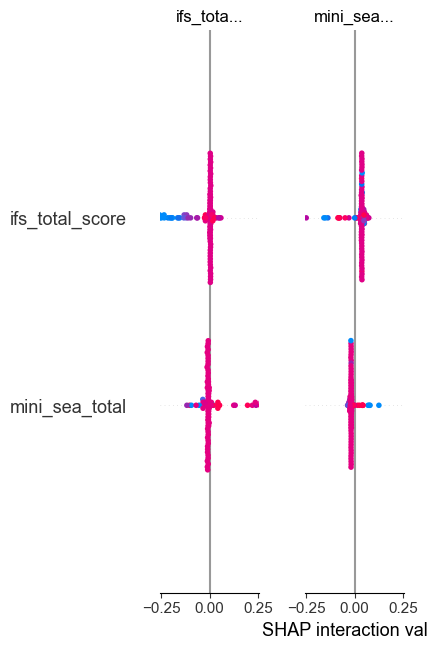

In [276]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

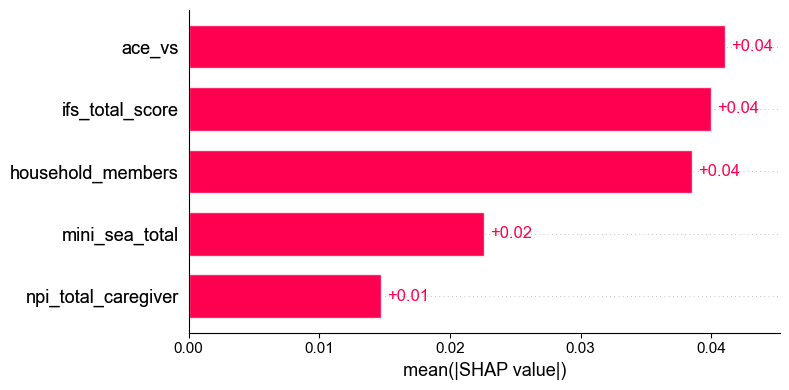

In [277]:
shap.plots.bar(shap_values[:,:,1])